In [1]:
#Let's go ahead and start with some imports
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
import pandas_datareader.data as web

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [2]:
import numba
from numba import cuda
import cupy as cp
import math

In [3]:
endtime = datetime.now()
start = datetime(endtime.year-1,endtime.month,endtime.day)
NVDA = web.DataReader('NVDA','yahoo',start,endtime)

In [4]:
NVDA

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-07-22,198.869995,192.759995,196.419998,195.940002,32382600.0,195.806717
2021-07-23,197.000000,192.500000,196.559998,195.580002,19567200.0,195.446960
2021-07-26,194.419998,189.139999,193.110001,192.940002,20394300.0,192.808746
2021-07-27,196.220001,187.410004,192.649994,192.080002,24886300.0,191.949341
2021-07-28,196.460007,189.949997,193.190002,195.029999,20219100.0,194.897308
...,...,...,...,...,...,...
2022-07-18,168.970001,160.020004,163.020004,161.009995,67051700.0,161.009995
2022-07-19,171.100006,161.720001,164.860001,169.919998,70236600.0,169.919998
2022-07-20,179.330002,168.009995,169.470001,178.070007,76053800.0,178.070007


In [5]:
rets = NVDA['Adj Close'].pct_change().dropna()
rets

Date
2021-07-23   -0.001837
2021-07-26   -0.013498
2021-07-27   -0.004457
2021-07-28    0.015358
2021-07-29    0.008153
                ...   
2022-07-18    0.021507
2022-07-19    0.055338
2022-07-20    0.047964
2022-07-21    0.013646
2022-07-22   -0.040499
Name: Adj Close, Length: 252, dtype: float64

<AxesSubplot:xlabel='Date'>

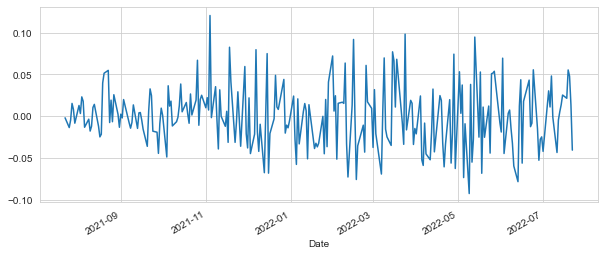

In [6]:
rets.plot(legend=False,figsize=(10,4))

In [7]:
rets.quantile(0.05)

-0.05810632972297609

In [8]:
rets.dtype

dtype('float64')

In [9]:
NVDA['Adj Close'][0].dtype

dtype('float64')

In [10]:
#Value at risk - "Monte Carlo Method"
#Run many random trials, and calculate an aggregation of the simulations to determine risk of a stock.
#try on NVDA

days = 365
dt = 1/days
mu = rets.mean()
sigma = rets.std()
start_price = NVDA['Adj Close'][0]

In [11]:
%%time
runs = 1000000

@numba.jit (nopython=True)
def gen_rand_states(runs,days,dt,mu,sigma):
    
    tmp = np.zeros(shape=(runs,days))
    for i in range(runs):
        for j in range (1,days):
            tmp[i][j] = np.random.normal(loc = mu*dt, scale = sigma*np.sqrt(dt))
    return tmp

shock = gen_rand_states(runs,days,dt,mu,sigma)

CPU times: total: 6.27 s
Wall time: 6.26 s


In [12]:
%%time
#sending arrays to device
output = np.zeros(runs)

dev_shk = cuda.to_device(shock)
dev_out = cuda.to_device(output)

CPU times: total: 500 ms
Wall time: 518 ms


In [13]:
@cuda.jit
def stock_monte_carlo(startprice,shock,days,mu,sigma,output):
    ''' This function takes in starting stock price, days of simulation,mu,sigma, and returns simulated price array'''
    
    thread_idx = cuda.grid(1)
    dt = 1/days
    drift = mu*dt
    
    # Run price array for number of days
    current = startprice
    prev = startprice
    for x in range(1,days):
        tmp = current
        current = prev + (prev * (drift + shock[thread_idx][x]))
        prev = tmp
        cuda.syncthreads()
        
    output[thread_idx] = current

In [14]:
threads_per_blk = 128
blk_per_grid = (dev_out.size + (threads_per_blk - 1)) // threads_per_blk
print(blk_per_grid)

7813


In [15]:
%%time
stock_monte_carlo[blk_per_grid,threads_per_blk](start_price,dev_shk,days,mu,sigma,dev_out)

simulations = dev_out.copy_to_host()
print(simulations)

[197.91907494 207.61924216 199.08366811 ... 203.56150416 196.89097762
 195.90450376]
CPU times: total: 172 ms
Wall time: 174 ms


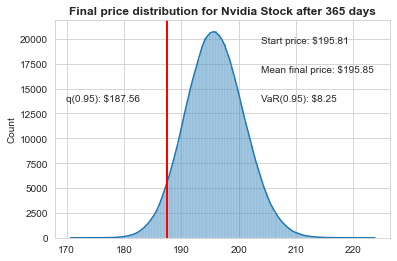

In [16]:
q = np.percentile(simulations,5)
sns.histplot(simulations,bins=200,kde=True)

#text above figure

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 95% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.95): $%.2f" % (start_price - q))

# Display 5% quantile
plt.figtext(0.15, 0.6, "q(0.95): $%.2f" % q)

# Plot a line at the 5% quantile result
plt.axvline(x=q, linewidth=2, color='r')

# Title
plt.title(u"Final price distribution for Nvidia Stock after %s days" % days, weight='bold');

In [17]:
print(shock.size*shock.itemsize)

2920000000
